# Week 6 - Exercise 1

Author: Khushee Kapoor

Registration Number: 200968052

Last Updated: 18/9/22

## Setting Up

**Meta-Data** of the dataset: (Name / Data Type / Measurement / Description)

- Elevation / quantitative /meters / Elevation in meters
- Aspect / quantitative / azimuth / Aspect in degrees azimutth
- Slope / quantitative / degrees / Slope in degrees
- Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway
- Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice
- Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice
- Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation
- Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation
- Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

To set up, we import the following libraries:

- math: for mathematical functions
- numpy: for data manipulation
- pandas: for data manipulation
- matplotlib: for data visualization
- seaborn: for data visualization
- tensorflow: to build neural networks

In [1]:
# importing libraries
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf

Next, we read the dataset from the link given using the read_csv() function from the Pandas library.

In [2]:
# reading the dataset
data_url = ('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz')
raw_data = pd.read_csv(data_url, header=None)

To check if we have read the data correctly, we use the head() funtion from the Pandas library to view the first few rows.

In [3]:
# viewing the first few rows
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


The two categorical features in the dataset are binary-encoded. We will convert this dataset representation to the typical representation, where each categorical feature is represented as a single integer value.

In [4]:
# converting the categorical features to be represented as a single integer value
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]
soil_type = raw_data.loc[:, 14:53].apply(lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)
wilderness_area = raw_data.loc[:, 10:13].apply(lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)
data = pd.concat([raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]], axis=1, ignore_index=True)

To make the data more readable, we add in the column labels from the metadata of the dataset.

In [5]:
# adding column labels
column_labels = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am",
                  "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points", "Wilderness_Area", "Soil_Type", "Cover_Type"]
data.columns = column_labels

For ease in computation, we convert the target labels from 1-7 to be 0-6 by subtracting one from all the values.

In [6]:
# converting the target labels
data["Cover_Type"] = data["Cover_Type"] - 1

Next, we split the dataset into training and testing sets. We allocate 85% to training and 15% to the testing set.

In [7]:
train_splits = []
test_splits = []

# splitting the dataset
for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

# saving the training and testing sets as csv files
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"
train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

To make the meta-data more readable, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.

In [8]:
# defining the target feature names and labels
target_feature_name = "Cover_Type"
target_feature_labels = ["0", "1", "2", "3", "4", "5", "6"]

# defining the numeric feature names
numeric_feature_names = ["Aspect", "Elevation", "Hillshade_3pm", "Hillshade_9am", "Hillshade_Noon", "Horizontal_Distance_To_Fire_Points", "Horizontal_Distance_To_Hydrology", 
                         "Horizontal_Distance_To_Roadways", "Slope", "Vertical_Distance_To_Hydrology"]

# defining the categorical feature names
categorical_features_vocabulary = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}
categorical_feature_names = list(categorical_features_vocabulary.keys())

# combining the numeric and categorical features
feature_names = numeric_feature_names + categorical_feature_names

# defining the column defaults
column_defaults = [
    [0] if feature_name in numeric_feature_names + [target_feature_name] else ["NA"]
    for feature_name in column_labels
]

# obtaining the number of classes
num_classes = len(target_feature_labels)

Next, we define the hyperparameters for training the model.

In [9]:
# defining the hyperparameters
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50
hidden_units = [32, 32]

We then prepare the training and testing sets by combining them with the above defined meta data.

In [10]:
# preparing the training and testing sets
train_dataset = tf.data.experimental.make_csv_dataset(train_data_file, batch_size=batch_size, column_names=column_labels, column_defaults=column_defaults,
        label_name=target_feature_name, num_epochs=1, header=True, shuffle=False).cache()
test_dataset = tf.data.experimental.make_csv_dataset(test_data_file, batch_size=batch_size, column_names=column_labels, column_defaults=column_defaults,
        label_name=target_feature_name, num_epochs=1, header=True, shuffle=False).cache()

## Feed-Forward Network

To begin, we define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.

In [11]:
# defining the inputs
inputs = {}
for feature_name in feature_names:
    if feature_name in numeric_feature_names:
        inputs[feature_name] = tf.keras.layers.Input(name=feature_name, shape=(), dtype=tf.float32)
    else:
        inputs[feature_name] = tf.keras.layers.Input(name=feature_name, shape=(), dtype=tf.string)

Next, we create a sparse representation of our input features wherein the categorical features are encoded with one-hot encoding.

In [12]:
# creating a sparse representation
encoded_features = []
for feature_name in inputs:
    if feature_name in categorical_feature_names:
        vocabulary = categorical_features_vocabulary[feature_name]
        lookup = tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0, output_mode="binary")
        encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
    else:
        encoded_feature = tf.expand_dims(inputs[feature_name], -1)
    encoded_features.append(encoded_feature)

features = tf.keras.layers.concatenate(encoded_features)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


After that, we create two Dense layers with the given specifications. Then we create an Output layer and link the layers with the input and output.

In [13]:
# creating two Dense layers
for units in hidden_units: 
  features = tf.keras.layers.Dense(units)(features)
  features = tf.keras.layers.BatchNormalization()(features)
  features = tf.keras.layers.ReLU()(features)
  features = tf.keras.layers.Dropout(dropout_rate)(features)

# creating an output layer
outputs = tf.keras.layers.Dense(units=num_classes, activation="softmax")(features)

# linking the layers with input and output
basic_model = tf.keras.Model(inputs=inputs, outputs=outputs)

Next compile the model and set the optimizer to be 'adam', loss to be SparseCategoricalCrossentropy and metric to be SparseCategoricalAccuracy. After that, we train the model on the training data with number of epochs set to the predefined value.

In [14]:
# compiling the model
basic_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# training the model
basic_history = basic_model.fit(train_dataset, epochs=num_epochs, batch_size=batch_size)

Epoch 1/50
1864/1864 [==============================] - 16s 8ms/step - loss: 0.7735 - sparse_categorical_accuracy: 0.6781
Epoch 2/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6645 - sparse_categorical_accuracy: 0.7138
Epoch 3/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.7247
Epoch 4/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6181 - sparse_categorical_accuracy: 0.7359
Epoch 5/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.6058 - sparse_categorical_accuracy: 0.7405
Epoch 6/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5958 - sparse_categorical_accuracy: 0.7446
Epoch 7/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5896 - sparse_categorical_accuracy: 0.7476
Epoch 8/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5834 - sparse_categorical_accuracy: 0.7488
Epoch 9/50
1864/1864 [==

## Wide & Deep Model

To begin, we define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.

In [15]:
# defining the inputs
inputs = {}
for feature_name in feature_names:
    if feature_name in numeric_feature_names:
        inputs[feature_name] = tf.keras.layers.Input(name=feature_name, shape=(), dtype=tf.float32)
    else:
        inputs[feature_name] = tf.keras.layers.Input(name=feature_name, shape=(), dtype=tf.string)

Next, we create a sparse representation of our input features wherein the categorical features are encoded with one-hot encoding for the wide part of the model.

In [16]:
# creating a sparse representation for the wide part
encoded_features = []
for feature_name in inputs:
    if feature_name in categorical_feature_names:
        vocabulary = categorical_features_vocabulary[feature_name]
        lookup = tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0, output_mode="binary")
        encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
    else:
        encoded_feature = tf.expand_dims(inputs[feature_name], -1)
    encoded_features.append(encoded_feature)

wide = tf.keras.layers.concatenate(encoded_features)
wide = tf.keras.layers.BatchNormalization()(wide)

After that, we create a dense represenation of our input features wherein the categorical features are encoded with low-dimensional embeddings for the deep part of the model.

In [17]:
# creating a dense representation for the deep part
encoded_features = []
for feature_name in inputs:
    if feature_name in categorical_feature_names:
        vocabulary = categorical_features_vocabulary[feature_name]
        lookup = tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0, output_mode="int")
        encoded_feature = lookup(inputs[feature_name])
        embedding_dims = int(math.sqrt(len(vocabulary)))
        embedding = tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=embedding_dims)
        encoded_feature = embedding(encoded_feature)
    else:
        encoded_feature = tf.expand_dims(inputs[feature_name], -1)

    encoded_features.append(encoded_feature)

deep = tf.keras.layers.concatenate(encoded_features)

Now, we create a deep network having two layers and predefined specifications, and merge it with the wide part. Then we create an Output layer and link the layers with the input and output.

In [18]:
# creating a deep network
for units in hidden_units:
  deep = tf.keras.layers.Dense(units)(deep)
  deep = tf.keras.layers.BatchNormalization()(deep)
  deep = tf.keras.layers.ReLU()(deep)
  deep = tf.keras.layers.Dropout(dropout_rate)(deep)

# merging the wide and deep network
merged = tf.keras.layers.concatenate([wide, deep])

# creating an output layer
outputs = tf.keras.layers.Dense(units=num_classes, activation="softmax")(merged)

# linking the layers with the input and output
wide_deep_model = tf.keras.Model(inputs=inputs, outputs=outputs)

Next compile the model and set the optimizer to be 'adam', loss to be SparseCategoricalCrossentropy and metric to be SparseCategoricalAccuracy. After that, we train the model on the training data with number of epochs set to the predefined value.

In [19]:
# compiling the model
wide_deep_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# training the model
wide_deep_history = wide_deep_model.fit(train_dataset, epochs=num_epochs, batch_size=batch_size)

Epoch 1/50
1864/1864 [==============================] - 15s 7ms/step - loss: 0.7041 - sparse_categorical_accuracy: 0.7061
Epoch 2/50
1864/1864 [==============================] - 13s 7ms/step - loss: 0.6042 - sparse_categorical_accuracy: 0.7383
Epoch 3/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5887 - sparse_categorical_accuracy: 0.7438
Epoch 4/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5761 - sparse_categorical_accuracy: 0.7499
Epoch 5/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5662 - sparse_categorical_accuracy: 0.7545
Epoch 6/50
1864/1864 [==============================] - 13s 7ms/step - loss: 0.5581 - sparse_categorical_accuracy: 0.7591
Epoch 7/50
1864/1864 [==============================] - 13s 7ms/step - loss: 0.5525 - sparse_categorical_accuracy: 0.7611
Epoch 8/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5467 - sparse_categorical_accuracy: 0.7639
Epoch 9/50
1864/1864 [==

## Deep & Cross Model

To begin, we define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.

In [20]:
# defining the inputs
inputs = {}
for feature_name in feature_names:
    if feature_name in numeric_feature_names:
        inputs[feature_name] = tf.keras.layers.Input(name=feature_name, shape=(), dtype=tf.float32)
    else:
        inputs[feature_name] = tf.keras.layers.Input(name=feature_name, shape=(), dtype=tf.string)

After that, we create a dense represenation of our input features wherein the categorical features are encoded with low-dimensional embeddings for the deep part of the model.

In [21]:
# creating a dense representation for the deep part
encoded_features = []
for feature_name in inputs:
    if feature_name in categorical_feature_names:
        vocabulary = categorical_features_vocabulary[feature_name]
        lookup = tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0, output_mode="int")
        encoded_feature = lookup(inputs[feature_name])
        embedding_dims = int(math.sqrt(len(vocabulary)))
        embedding = tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=embedding_dims)
        encoded_feature = embedding(encoded_feature)
    else:
        encoded_feature = tf.expand_dims(inputs[feature_name], -1)

    encoded_features.append(encoded_feature)

x0 = tf.keras.layers.concatenate(encoded_features)

Now, we create a cross part in a way that the explicit feature crossing are applied in an efficient way, where the degree of cross features grows with layer depth. Next, we create a deep network having two layers and predefined specifications, and merge it with the cross part. Then we create an Output layer and link the layers with the input and output.

In [22]:
# creating the cross part
cross = x0
for _ in hidden_units:
    units = cross.shape[-1]
    x = tf.keras.layers.Dense(units)(cross)
    cross = x0 * x + cross
cross = tf.keras.layers.BatchNormalization()(cross)

deep = x0

# creating a deep network
for units in hidden_units:
    deep = tf.keras.layers.Dense(units)(deep)
    deep = tf.keras.layers.BatchNormalization()(deep)
    deep = tf.keras.layers.ReLU()(deep)
    deep = tf.keras.layers.Dropout(dropout_rate)(deep)

# merging the cross and deep part
merged = tf.keras.layers.concatenate([cross, deep])

# creating an output layer
outputs = tf.keras.layers.Dense(units=num_classes, activation="softmax")(merged)

# linking the layers with the inputs and outputs
deep_cross_model = tf.keras.Model(inputs=inputs, outputs=outputs)

Next compile the model and set the optimizer to be 'adam', loss to be SparseCategoricalCrossentropy and metric to be SparseCategoricalAccuracy. After that, we train the model on the training data with number of epochs set to the predefined value.

In [23]:
# compiling the model
deep_cross_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# training the model
deep_cross_history = deep_cross_model.fit(train_dataset, epochs=num_epochs, batch_size=batch_size)

Epoch 1/50
1864/1864 [==============================] - 13s 6ms/step - loss: 0.6995 - sparse_categorical_accuracy: 0.7101
Epoch 2/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7439
Epoch 3/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5757 - sparse_categorical_accuracy: 0.7493
Epoch 4/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5644 - sparse_categorical_accuracy: 0.7536
Epoch 5/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5568 - sparse_categorical_accuracy: 0.7562
Epoch 6/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5507 - sparse_categorical_accuracy: 0.7596
Epoch 7/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.7621
Epoch 8/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5421 - sparse_categorical_accuracy: 0.7631
Epoch 9/50
1864/1864 [==

## Comparison

To compare the loss of the models, we plot them using the history attribute in a single plot and differentiate between them by giving different colors and appropriate labels using functions from the matplotlib library.

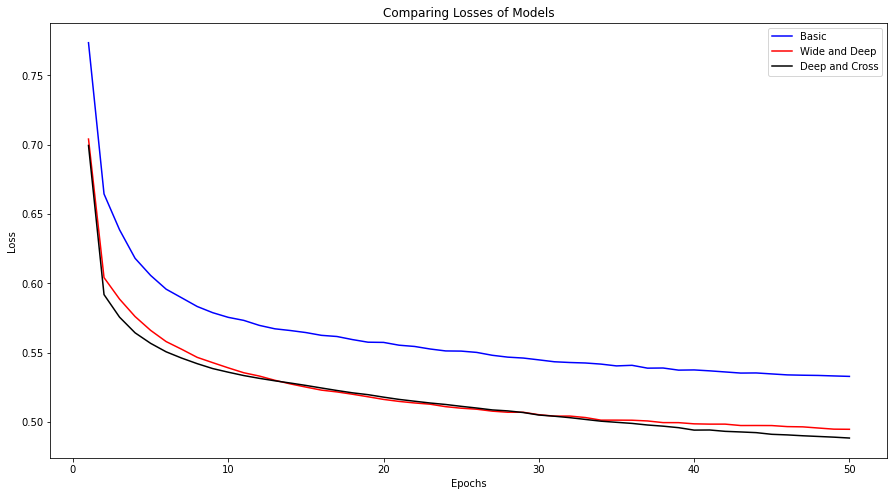

In [24]:
# plotting the losses of the models
epochs = range(1, 51)
plt.figure(figsize=(15,8))
plt.plot(epochs, basic_history.history['loss'], 'b', label='Basic')
plt.plot(epochs, wide_deep_history.history['loss'], 'r', label='Wide and Deep')
plt.plot(epochs, deep_cross_history.history['loss'], 'k', label='Deep and Cross')
plt.title('Comparing Losses of Models')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

As we can see, the loss of all the three models decreases and then plateuas. However, there is a significant difference between the basic model and the wide & deep and deep & cross models, which have very less difference, with basic model having higher loss than the other two.

To compare the accuracy of the models, we plot them using the history attribute in a single plot and differentiate between them by giving different colors and appropriate labels using functions from the matplotlib library.

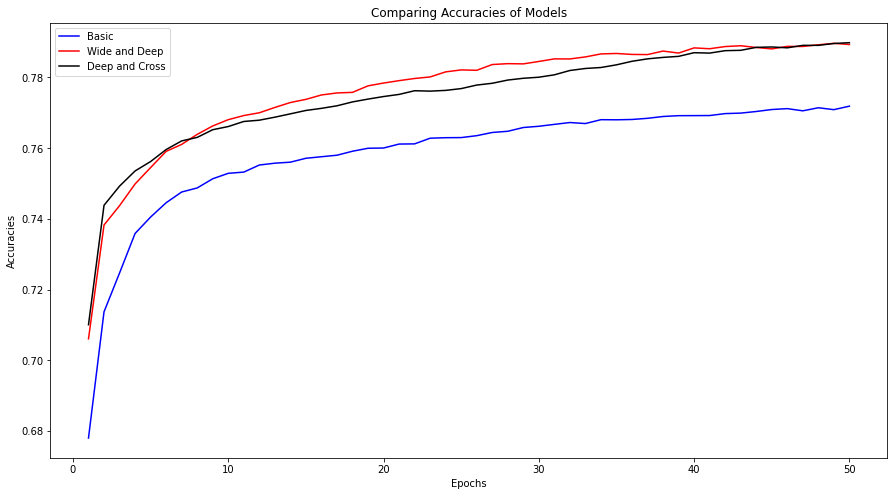

In [25]:
# plotting the accuracies of the models
epochs = range(1, 51)
plt.figure(figsize=(15,8))
plt.plot(epochs, basic_history.history['sparse_categorical_accuracy'], 'b', label='Basic')
plt.plot(epochs, wide_deep_history.history['sparse_categorical_accuracy'], 'r', label='Wide and Deep')
plt.plot(epochs, deep_cross_history.history['sparse_categorical_accuracy'], 'k', label='Deep and Cross')
plt.title('Comparing Accuracies of Models')
plt.ylabel('Accuracies')
plt.xlabel('Epochs')
plt.legend()

As we can see, the accuracy of all the three models increases and then plateuas. However, there is a significant difference between the basic model and the wide & deep and deep & cross models, which have very less difference, with basic model having lower accuracy than the other two.

Next, we evaluate the models on the test set using the evaluate() function. First, we compare the loss.

In [26]:
# comparing the loss
print(str.format('Loss of Basic Model on Test Set: {:.5f}', basic_model.evaluate(test_dataset, verbose=0)[0]))
print(str.format('Loss of Wide & Deep Model on Test Set: {:.5f}', wide_deep_model.evaluate(test_dataset, verbose=0)[0]))
print(str.format('Loss of Deep & Cross Model on Test Set: {:.5f}', deep_cross_model.evaluate(test_dataset, verbose=0)[0]))

Loss of Basic Model on Test Set: 0.65638
Loss of Wide & Deep Model on Test Set: 0.44760
Loss of Deep & Cross Model on Test Set: 0.46343


As we can see, the basic model has a higher loss than the wide & deep and deep & cross models, which are almost the same with the former being slightly less.

Next, we compare the accuracy.

In [27]:
# comparing the accuracy
print(str.format('Accuracy of Basic Model on Test Set: {:.2f}%', basic_model.evaluate(test_dataset, verbose=0)[1]*100))
print(str.format('Accuracy of Wide & Deep Model on Test Set: {:.2f}%', wide_deep_model.evaluate(test_dataset, verbose=0)[1]*100))
print(str.format('Accuracy of Deep & Cross Model on Test Set: {:.2f}%', deep_cross_model.evaluate(test_dataset, verbose=0)[1]*100))

Accuracy of Basic Model on Test Set: 73.60%
Accuracy of Wide & Deep Model on Test Set: 80.94%
Accuracy of Deep & Cross Model on Test Set: 80.10%


As we can see, the basic model has a lower accuracy than the wide & deep and deep & cross models, which are almost the same with the former being slightly more.